# Filometro em mapa

Algumas cidades como São Paulo, Salvador e São Luís criaram um "filometro" para mostrar como andam as filas nos diversos postos de vacinação para covid.

https://deolhonafila.prefeitura.sp.gov.br/  
https://filometro.saude.salvador.ba.gov.br/  
http://semit.saoluis.ma.gov.br/filometro/  

Seria interessante colocar estas informações num mapa, para cada pessoa verificar quais são as opções mais perto dela para se vacinar evitando aglomerações.

Inspiração:

https://youtu.be/W0L2DW-6HXs?t=105

# Instalações e Importações

In [ ]:
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver

In [1]:
from selenium import webdriver
import time
import pandas as pd
from datetime import datetime

# Scraping

In [2]:
#launch url
url = "https://deolhonafila.prefeitura.sp.gov.br/"

def get_info_sp(url, save_to_csv=True):
    
    #### SCRAPING ####
    
    # Initialize browser driver
    
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome('chromedriver', options=chrome_options)
    
    # opening URL
    driver.get(url)
    time.sleep(5)
    
    # list of lists with 5 elements each
    vaccination_places_list = []
    
    all_locations = driver.find_elements_by_css_selector(".msg")

    for vaccination_place in all_locations:

        name = vaccination_place.find_element_by_xpath('.//h6[1]').get_attribute('innerText')
        modality = vaccination_place.find_element_by_xpath('.//h6[2]').get_attribute('innerText')
        adress = vaccination_place.find_element_by_xpath('.//h11[1]').get_attribute('innerText')
        queue_situation = vaccination_place.find_element_by_xpath('.//h11[2]').get_attribute('innerText')
        last_update = vaccination_place.find_element_by_xpath('.//h11[3]').get_attribute('innerText')

        vaccination_place_info = [name, modality, adress, queue_situation, last_update]

        vaccination_places_list.append(vaccination_place_info)

    # close browser
    driver.quit()
    
    
    #### TRANSFORMING LIST INTO PANDAS DATAFRAME ####

    vaccination_places_df = pd.DataFrame(vaccination_places_list)
    vaccination_places_df.columns = ['nome', 'modalidade', 'endereco', 'situacao_fila', 'ultima_atualizacao']
    
    # data cleaning and formatting
    for column in ('modalidade', 'situacao_fila', 'ultima_atualizacao'):
        vaccination_places_df[column] = [item.split(": ")[1] for item in vaccination_places_df[column]]
    
    vaccination_places_df['ultima_atualizacao'] = pd.to_datetime(vaccination_places_df['ultima_atualizacao'])
    
    # saving to csv
    if save_to_csv:
        city = 'sp_'
        timestamp = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
        path = city +'vac_' + timestamp + '.csv'
        vaccination_places_df.to_csv(path, sep=";")
    
    return vaccination_places_df
    
    
df = get_info_sp(url)
# vaccination_places_df.index.size # == 516

# Conhecendo os Dados

In [3]:
df.shape

(520, 5)

Temos 520 Postos de Vacinação neste arquivo, mas no dia 18/junho esse número era de 516.

In [5]:
df.head()

,nome,modalidade,endereco,situacao_fila,ultima_atualizacao
0,AMA/UBS INTEGRADA JARDIM PAULISTANO / IGREJA B...,POSTO VOLANTE,"IGREJA: R. APARECIDA DO TABOADO,505 - JD PAULI...",SEM FILA,2021-06-24 19:01:00
1,UBS VILA TEREZINHA / CRECHE BATUIRA,POSTO VOLANTE,"CRECHE BATUIRA: R. Jorge Píres Ramalho, 70 - V...",NÃO FUNCIONANDO,2021-06-24 19:00:00
2,UBS CASA VERDE / PARÓQUIA NOSSA SENHORA DAS DORES,POSTO VOLANTE,"R. ANTONIETA, 19 - CASA VERDE BAIXA - CEP: 025...",SEM FILA,2021-06-24 19:00:00
3,POSTO VOLANTE CENTER NORTE,POSTO VOLANTE,"Rua Otto Baumgart, 500",SEM FILA,2021-06-24 16:56:00
4,IGREJA DE SÃO JUDAS,POSTO VOLANTE,"Alameda Guaiós,145",FILA GRANDE,2021-06-24 16:12:00


Verificação de nulos

In [7]:
df.isna().sum()

nome                  0
modalidade            0
endereco              0
situacao_fila         0
ultima_atualizacao    0
dtype: int64

In [8]:
df[df['ultima_atualizacao'].isnull()]

,nome,modalidade,endereco,situacao_fila,ultima_atualizacao


In [9]:
df[df.situacao_fila == '']

,nome,modalidade,endereco,situacao_fila,ultima_atualizacao


In [10]:
df.situacao_fila.unique()

array(['SEM FILA', 'NÃO FUNCIONANDO', 'FILA GRANDE',
       'AGUARDANDO ABASTECIMENTO', 'FILA PEQUENA', 'FILA MÉDIA'],
      dtype=object)

<div class="alert alert-success"> Temos 6 situações de fila.</div>

In [11]:
df.modalidade.unique()

array(['POSTO VOLANTE', 'DRIVE-THRU', 'MEGAPOSTO', 'POSTO FIXO'],
      dtype=object)

<div class="alert alert-success">Temos 4 tipos de postos de vacinação</div>

In [12]:
df.ultima_atualizacao.max() - df.ultima_atualizacao.min()

Timedelta('0 days 04:56:00')

<div class="alert alert-success">Sobre a variação de tempo, parece ser a cada x horas, com alguns atrasos recorrentes.</div>

In [45]:
pd.date_range('15:00', '19:00', freq= '1h').time

array([datetime.time(15, 0), datetime.time(16, 0), datetime.time(17, 0),
       datetime.time(18, 0), datetime.time(19, 0)], dtype=object)

<ipython-input-60-03b79631b1ad>:1: UserWarning: FixedFormatter should only be used together with FixedLocator
  df.ultima_atualizacao\


[Text(0.5, 1.0, 'Histograma por Horário de Atualização'),
 [Text(18802.625, 0, '15:00:00'),
  Text(18802.666666666668, 0, '16:00:00'),
  Text(18802.708333333332, 0, '17:00:00'),
  Text(18802.75, 0, '18:00:00'),
  Text(18802.791666666668, 0, '19:00:00')]]

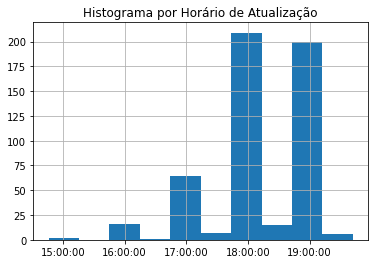

In [60]:
df.ultima_atualizacao\
    .sort_values()\
    .hist()\
    .set(title = 'Histograma por Horário de Atualização',
         xticklabels = pd.date_range('15:00', '19:00', freq= '1h').time)

# Próxima Parte

Plotar isso num mapa